## Imports and Inputs

In [1]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
# import seaborn as sns
from datetime import datetime, timedelta, timezone

from dune_client.client import DuneClient
from config import key

# set pandas to display all rows for inspection
pd.set_option('display.max_rows', None)

/tmp/ipykernel_2141/3326899178.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [6]:
# import jsons of capital pool, ramm volume and covers from dune api 
dune = DuneClient(key)
cap_pool_result = dune.get_latest_result_dataframe(1442422)
ramm_volume_result = dune.get_latest_result_dataframe(3219988)
covers_list_result = dune.get_latest_result_dataframe(2303588)

In [7]:
# manually input the valuation date as a string in the format 'yyyy-mm-dd'
valn_date_str = '2024-03-31'

# manually input kiln rewards
kiln_rewards = 166.8124

In [14]:
# create valuation datetime
valn_date = datetime.strptime(valn_date_str, '%Y-%m-%d').replace(tzinfo=timezone.utc)
# create valuation datetimes for 30 days and 365 days ago
valn_date_minus_30 = valn_date - timedelta(days=30)
valn_date_minus_365 = valn_date - timedelta(days=365)

## Processing Capital Pool Table

In [8]:
# process capital pool table

df_cap_raw = cap_pool_result

# drop moving average columns
df_cap = df_cap_raw.drop(columns=['moving_average_eth', 'moving_average_dai', 'running_total_display_curr'])
# rename columns
df_cap.rename(columns={'running_net_eth_display_curr': 'ETH',
                   'running_net_dai_display_curr': 'DAI',
                   'running_net_rpl_display_curr': 'rETH',
                   'running_net_lido_display_curr': 'stETH',
                   'running_net_enzyme_display_curr': 'Enzyme',
                  }, inplace=True)


# turn <nil> values into 0 for rETH and turn into floats
df_cap['rETH'] = df_cap['rETH'].replace('<nil>', '0').astype('float')
# change day to a datetime
df_cap['day'] = pd.to_datetime(df_cap['day'])

# Adjust Enzyme for Kiln returns

    # create datetime object of 2023/08/30 when the Kiln validators were activated 
kiln_deposit_date = datetime(year=2023, month=8, day=30, tzinfo=timezone.utc)

    # work out days since kiln deposit from the latest day and work out the rewards per day
days_since_kiln = (df_cap.iloc[0]['day'] - kiln_deposit_date)/timedelta(days=1)
daily_kiln_rewards = kiln_rewards/days_since_kiln

    # create a column for kiln rewards based on the daily values since validators went live
df_cap['kiln_rewards'] = daily_kiln_rewards * (df_cap['day'] - kiln_deposit_date) / timedelta(days=1)
df_cap.loc[df_cap['kiln_rewards'] < 0, 'kiln_rewards'] = 0

    # Add Kiln rewards to Enzyme column and then drop the Kiln rewards column
df_cap['Enzyme'] = df_cap['Enzyme'] + df_cap['kiln_rewards']
df_cap.drop(columns=['kiln_rewards'], inplace=True)

# add all the columns except day together to get numeric total
df_cap['sum'] = df_cap.drop(columns=['day']).sum(axis=1)

In [9]:
df_cap

,day,ETH,DAI,rETH,stETH,Enzyme,sum
0,2024-04-03 00:00:00+00:00,29005.140102,1431.699992,14728.464131,33448.815984,13310.896644,91925.016852
1,2024-04-02 00:00:00+00:00,29049.712230,1416.964434,14727.389933,33448.815984,13310.127923,91953.010503
2,2024-04-01 00:00:00+00:00,29143.056873,1400.952183,14726.154293,33445.609935,13309.411426,92025.184710
3,2024-03-31 00:00:00+00:00,29215.746022,1395.701154,14724.125756,33442.746250,13308.694929,92087.014111
4,2024-03-30 00:00:00+00:00,29330.628501,1408.536484,14723.145109,33439.934931,13307.978439,92210.223463
5,2024-03-29 00:00:00+00:00,29465.812994,1417.410616,14722.792155,33437.079009,13307.261949,92350.356724
6,2024-03-28 00:00:00+00:00,29555.916803,1422.023515,14723.455901,33434.058570,13306.545453,92442.000243
7,2024-03-27 00:00:00+00:00,29688.065224,1424.457385,14723.836904,33431.141698,13305.828964,92573.330174
8,2024-03-26 00:00:00+00:00,29739.508180,1440.543407,14724.207954,33428.161845,13305.112467,92637.533852
9,2024-03-25 00:00:00+00:00,29875.041016,1457.991778,14724.917149,33424.988964,13304.395979,92787.334886


In [15]:
# ETH denominated 30-day returns on individual investments

# stETH metrics in ETH
stETH_closing = df_cap.loc[df_cap['day'] == valn_date]['stETH'].values[0]
# monthly
stETH_monthly_opening = df_cap.loc[df_cap['day'] == valn_date_minus_30]['stETH'].values[0]
stETH_monthly_return = stETH_closing - stETH_monthly_opening
# stETH monthly percentage
stETH_monthly_percentage = stETH_monthly_return / stETH_monthly_opening
# stETH annualised return last month
stETH_monthly_APY = ((1 + stETH_monthly_percentage) ** 12 - 1)
print(f'stETH Monthly APY: {round(stETH_monthly_APY * 100, 3)}%')

# rETH metrics in ETH
rETH_monthly_opening = df_cap.loc[df_cap['day'] == valn_date_minus_30]['rETH'].values[0]
rETH_closing = df_cap.loc[df_cap['day'] == valn_date]['rETH'].values[0]
rETH_monthly_return = rETH_closing - rETH_monthly_opening
# rETH monthly percentage
rETH_monthly_percentage = rETH_monthly_return / rETH_monthly_opening
# rETH annualised return last month
rETH_monthly_APY = ((1 + rETH_monthly_percentage) ** 12 - 1)
print(f'rETH Monthly APY: {round(rETH_monthly_APY * 100, 3)}%')

## Enzyme
Enzyme_fee = 0.0015
# Enzyme overall metrics in ETH
Enzyme_monthly_opening = df_cap.loc[df_cap['day'] == valn_date_minus_30]['Enzyme'].values[0]
Enzyme_closing = df_cap.loc[df_cap['day'] == valn_date]['Enzyme'].values[0]
Enzyme_monthly_return = Enzyme_closing - Enzyme_monthly_opening
# Enzyme monthly percentage
Enzyme_monthly_percentage = Enzyme_monthly_return / Enzyme_monthly_opening
# Enzyme annualised return last month
Enzyme_monthly_APY = ((1 + Enzyme_monthly_percentage) ** 12 - 1)
Enzyme_monthly_APY_after_fees = Enzyme_monthly_APY - Enzyme_fee
    
# Kiln standalone metrics in ETH
Enzyme_idle_portion = 6594 
Kiln_monthly_opening = Enzyme_monthly_opening - Enzyme_idle_portion
Kiln_closing = Enzyme_closing - Enzyme_idle_portion
Kiln_monthly_return = Kiln_closing - Kiln_monthly_opening
# Kiln monthly percentage
Kiln_monthly_percentage = Kiln_monthly_return / Kiln_monthly_opening
# Kiln annualised return last month
Kiln_monthly_APY = ((1 + Kiln_monthly_percentage) ** 12 - 1)
Kiln_monthly_APY_after_fees = Kiln_monthly_APY - Enzyme_fee

print(f'Enzyme Monthly APY: {round(Enzyme_monthly_APY_after_fees * 100, 3)}%; Kiln Portion Monthly APY: {round(Kiln_monthly_APY_after_fees * 100, 3)}%')
print ('All returns after fees')

stETH Monthly APY: 3.448%
rETH Monthly APY: 3.429%
Enzyme Monthly APY: 1.809%; Kiln Portion Monthly APY: 3.772%
All returns after fees


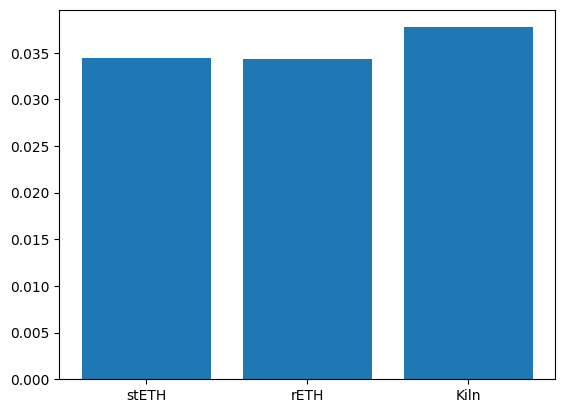

In [16]:
plt.bar(['stETH', 'rETH', 'Kiln'], [stETH_monthly_APY, rETH_monthly_APY, Kiln_monthly_APY_after_fees]);

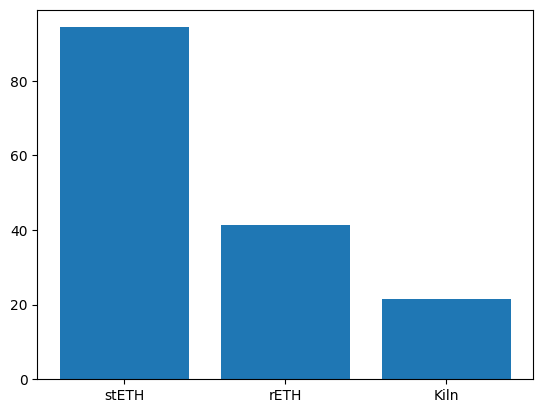

In [17]:
plt.bar(['stETH', 'rETH', 'Kiln'], [stETH_monthly_return, rETH_monthly_return, Kiln_monthly_return*(1-0.0015)]);

In [40]:
df_ramm = ramm_volume_result

# change timestamp to datetime format and normalise all dates to midnight
df_ramm['ts'] = pd.to_datetime(df_ramm['ts']).dt.floor('D').dt.tz_localize(timezone.utc)

# group by date, take the latest value and re-sort into descending order
df_ramm = df_ramm.groupby(by=df_ramm['ts'].dt.date, as_index=False).first().\
            sort_values(['ts'], ascending=False).reset_index(drop=True)

In [41]:
df_ramm.dtypes

ts                     datetime64[ns, UTC]
cummulative_eth_in                 float64
cummulative_eth_out                float64
cummulative_nxm_out                float64
cummulative_nxm_in                 float64
dtype: object

In [42]:
df_ramm['ts'][3]

Timestamp('2024-03-31 00:00:00+0000', tz='UTC')

In [43]:
valn_date

datetime.datetime(2024, 3, 31, 0, 0, tzinfo=datetime.timezone.utc)

In [44]:
df_ramm['ts'][3] == valn_date

True

In [45]:
ramm_flows_monthly_opening = df_ramm.loc[df_ramm['ts'] == valn_date_minus_30]['cummulative_eth_in'].values[0] - df_ramm.loc[df_ramm['ts'] == valn_date_minus_30]['cummulative_eth_out'].values[0]
ramm_flows_monthly_closing = df_ramm.loc[df_ramm['ts'] == valn_date]['cummulative_eth_in'].values[0] - df_ramm.loc[df_ramm['ts'] == valn_date]['cummulative_eth_out'].values[0]

ramm_flow_monthly_change = ramm_flows_monthly_closing - ramm_flows_monthly_opening
ramm_flow_monthly_change

-3078.218273673214

In [46]:
# get net monthly change from DAI
dai_monthly_opening = df_cap.loc[df_cap['day'] == valn_date_minus_30]['DAI'].values[0]
dai_monthly_closing = df_cap.loc[df_cap['day'] == valn_date]['DAI'].values[0]
dai_change = dai_monthly_closing - dai_monthly_opening

dai_change

-115.62653681414167

In [57]:
df_covers = covers_list_result

# change timestamp to datetime format
df_covers['cover_start_time'] = pd.to_datetime(df_covers['cover_start_time'])
df_covers.dtypes

cover_id                                        int64
active                                         object
cover_asset                                    object
native_cover_amount                           float64
dollar_value                                  float64
eth_value                                     float64
partial_cover_amount_in_nxm                   float64
cover_percentage                              float64
partial_cover_amount_in_eth                   float64
partial_cover_amount_in_dollar                float64
premium_asset                                  object
premium_nxm                                   float64
premium_native                                float64
premium_dollar                                float64
staking_pool                                   object
product_type                                   object
product_name                                   object
cover_start_time                  datetime64[ns, UTC]
cover_end_time              

In [58]:
df_covers

,cover_id,active,cover_asset,native_cover_amount,dollar_value,eth_value,partial_cover_amount_in_nxm,cover_percentage,partial_cover_amount_in_eth,partial_cover_amount_in_dollar,...,premium_native,premium_dollar,staking_pool,product_type,product_name,cover_start_time,cover_end_time,owner,cover_period,call_tx_hash
0,568,Active,ETH,2.100000e+02,7.589481e+05,210.000000,10009.62,0.027670,210.000102,7.589484e+05,...,4.307304e+00,15566.763102,2,Bundled Protocol Cover,EigenLayer + Ether.fi + Pendle,2024-03-26 07:44:59+00:00,2024-06-27 07:44:59.000 UTC,0xb15cdf0df08a2d35f21ce0c540c6381c02633dfc,93,0x350b97ada7183555e504c6db59c9cbb06e2b651af3e1...
1,567,Active,DAI,2.000000e+06,2.002546e+06,569.309505,26726.67,97.855567,557.101043,1.959603e+06,...,9.978211e+03,9990.915070,2,Protocol,Pendle,2024-03-25 22:33:59+00:00,2024-04-23 22:33:59.000 UTC,0xe5379345675132653bd303030c6e456034ed1961,29,0xce0810bde85c072fdd71035f4da7a3677802c8f83c78...
2,566,Active,ETH,2.500000e+01,8.793750e+04,25.000000,1200.03,0.028430,25.000221,8.793828e+04,...,2.835641e-01,997.436928,2,Protocol,Uniswap v3,2024-03-25 19:37:11+00:00,2024-09-21 19:37:11.000 UTC,0x7649ce955e999078b3fb8e484fe42f0dba02680e,180,0x2d9a5f7337e40ae08d4a8cc282a51320fdbb58b39fc6...
3,565,Active,DAI,1.000000e+06,1.001273e+06,284.654753,3422.25,25.047064,71.297657,2.507895e+05,...,1.966616e+03,1969.119772,2,Protocol,Pendle,2024-03-25 18:58:47+00:00,2024-04-23 18:58:47.000 UTC,0xe5379345675132653bd303030c6e456034ed1961,29,0xd0209b73e65bcdcf17c68018ce4abfb05ebdb673e0bd...
4,565,Active,DAI,1.000000e+06,1.001273e+06,284.654753,3538.51,25.897958,73.719767,2.593093e+05,...,1.160618e+03,1162.095915,22,Protocol,Pendle,2024-03-25 18:58:47+00:00,2024-04-23 18:58:47.000 UTC,0xe5379345675132653bd303030c6e456034ed1961,29,0xd0209b73e65bcdcf17c68018ce4abfb05ebdb673e0bd...
5,565,Active,DAI,1.000000e+06,1.001273e+06,284.654753,5598.95,40.978087,116.646072,4.103026e+05,...,3.787179e+03,3792.000963,4,Protocol,Pendle,2024-03-25 18:58:47+00:00,2024-04-23 18:58:47.000 UTC,0xe5379345675132653bd303030c6e456034ed1961,29,0xd0209b73e65bcdcf17c68018ce4abfb05ebdb673e0bd...
6,565,Active,DAI,1.000000e+06,1.001273e+06,284.654753,674.96,4.939957,14.061821,4.946246e+04,...,6.757103e+02,676.570602,1,Protocol,Pendle,2024-03-25 18:58:47+00:00,2024-04-23 18:58:47.000 UTC,0xe5379345675132653bd303030c6e456034ed1961,29,0xd0209b73e65bcdcf17c68018ce4abfb05ebdb673e0bd...
7,564,Active,DAI,1.930100e+04,1.932557e+04,5.494121,260.73,98.904247,5.433919,1.911381e+04,...,8.119579e+01,81.299160,22,Protocol,Aave V3,2024-03-25 14:54:35+00:00,2024-04-24 14:54:35.000 UTC,0xe4994082a0e7f38b565e6c5f4afd608de5eddfbb,30,0xbe8c9d40f7deb46ddc329bc0ff855fb236713dc1c6a1...
8,563,Active,ETH,2.650000e+02,9.321375e+05,265.000000,12718.40,0.028429,265.000334,9.321387e+05,...,3.949231e+00,13891.420621,1,Protocol,Pendle,2024-03-25 03:56:11+00:00,2024-06-19 03:56:11.000 UTC,0xb15cdf0df08a2d35f21ce0c540c6381c02633dfc,86,0x939c67b047c6eadb19c15829be1046c82ba44e1d9332...
9,562,Active,ETH,7.800000e+01,2.743650e+05,78.000000,3722.67,0.028429,78.000171,2.743656e+05,...,2.211786e-01,777.995641,2,Protocol,"Safe (formerly, Gnosis Safe)",2024-03-25 02:26:59+00:00,2024-06-23 02:26:59.000 UTC,0x056dfb32dfe7c27884c1eb6bfaf8858f02180887,90,0xd4e890bfd8ec022510b1552bc6544eb7e702a4b0e629...


In [59]:
datetime.today()

datetime.datetime(2024, 3, 27, 12, 7, 51, 413838)

In [20]:
# opening total ETH value of capital pool
total_cap_monthly_opening = df_cap.iloc[30]['sum']
total_cap_monthly_closing = df_cap.iloc[0]['sum']

total_cap_monthly_opening
total_cap_monthly_closing

95653.37329348111